## Optimización de modelos

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils.base_models import BaseModels
from utils.categorical_encoders import CategoricalEncoders

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

In [26]:
# 0. Definir seed
seed = 16
np.random.seed(seed)

In [27]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])

# Seleccionar aleatoriamente el 10% de los datos
dataset = dataset.sample(frac=0.002, random_state=42)
print(dataset.shape)
print(dataset['TARGET'].value_counts())

(2611, 14)
TARGET
0    1371
1    1240
Name: count, dtype: int64


In [28]:
# 2. Crear dataset con los encoders
categorical_encoders = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical_encoders.get_binary_categorical_columns()

data = categorical_encoders.provider(binary_columns, categorical_columns, method='BackwardDifferenceEncoder')

# 3. Split dataset
X = data.drop(columns=['TARGET'])
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
# Validación cruzada (Cross-Validation)
model = RandomForestClassifier(n_estimators=100, random_state=seed)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-Validation Accuracy: 0.745 (+/- 0.038)


In [34]:
# Búsqueda en malla (Grid Search)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters from Grid Search: {grid_search.best_params_}")
print(f"Best score from Grid Search: {grid_search.best_score_:.3f}")

# Evaluar el mejor modelo encontrado por Grid Search
best_model_grid = grid_search.best_estimator_
test_pred_grid = best_model_grid.predict(X_test)
accuracy_grid = accuracy_score(y_test, test_pred_grid)
tn, fp, fn, tp = confusion_matrix(y_test, test_pred_grid).ravel()
sensitivity_grid = tp / (tp + fn)
specificity_grid = tn / (tn + fp)
gini_grid = 2 * roc_auc_score(y_test, best_model_grid.predict_proba(X_test)[:, 1]) - 1
auc_grid = roc_auc_score(y_test, best_model_grid.predict_proba(X_test)[:, 1])

Best parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score from Grid Search: 0.771


In [35]:
# Búsqueda aleatoria (Random Search)
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=seed), param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=seed)
random_search.fit(X_train, y_train)
print(f"Best parameters from Random Search: {random_search.best_params_}")
print(f"Best score from Random Search: {random_search.best_score_:.3f}")

# Evaluar el mejor modelo encontrado por Random Search
best_model_random = random_search.best_estimator_
test_pred_random = best_model_random.predict(X_test)
accuracy_random = accuracy_score(y_test, test_pred_random)
tn, fp, fn, tp = confusion_matrix(y_test, test_pred_random).ravel()
sensitivity_random = tp / (tp + fn)
specificity_random = tn / (tn + fp)
gini_random = 2 * roc_auc_score(y_test, best_model_random.predict_proba(X_test)[:, 1]) - 1
auc_random = roc_auc_score(y_test, best_model_random.predict_proba(X_test)[:, 1])

Best parameters from Random Search: {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 130}
Best score from Random Search: 0.771


In [36]:
# Guardar los mejores resultados de los modelos optimizados
consolidated_results = [
    ('grid_search', auc_grid, accuracy_grid, sensitivity_grid, specificity_grid, gini_grid),
    ('random_search', auc_random, accuracy_random, sensitivity_random, specificity_random, gini_random)
]

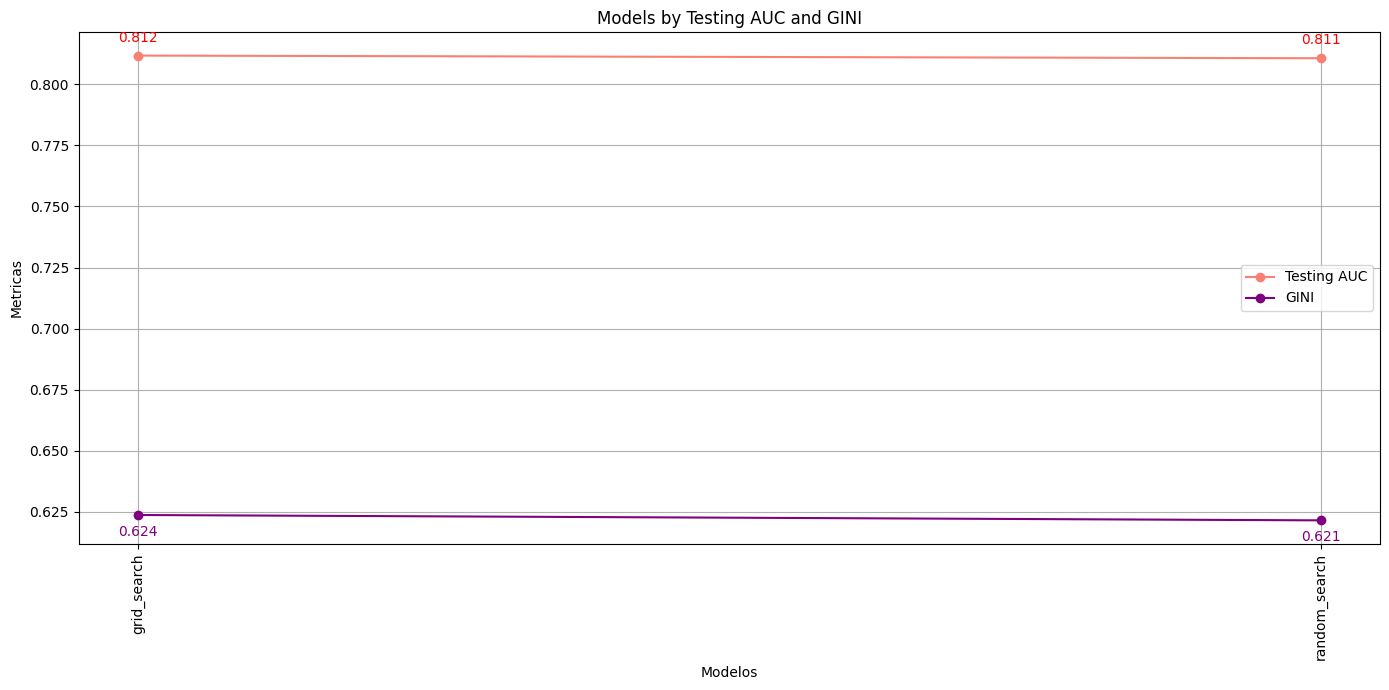

In [38]:
# Desempaquetar los resultados
all_names, all_test_aucs, all_accuracies, all_sensitivities, all_specificities, all_ginis = zip(*consolidated_results)

# Gráfico 1: GINI y AUC
plt.figure(figsize=(14, 7))
plt.plot(all_names, all_test_aucs, label='Testing AUC', marker='o', color='salmon')
plt.plot(all_names, all_ginis, label='GINI', marker='o', color='purple')

# Añadir los valores a los puntos
for i, txt in enumerate(all_test_aucs):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_test_aucs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
for i, txt in enumerate(all_ginis):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_ginis[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='purple')

plt.xlabel('Modelos')
plt.ylabel('Metricas')
plt.title('Models by Testing AUC and GINI')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

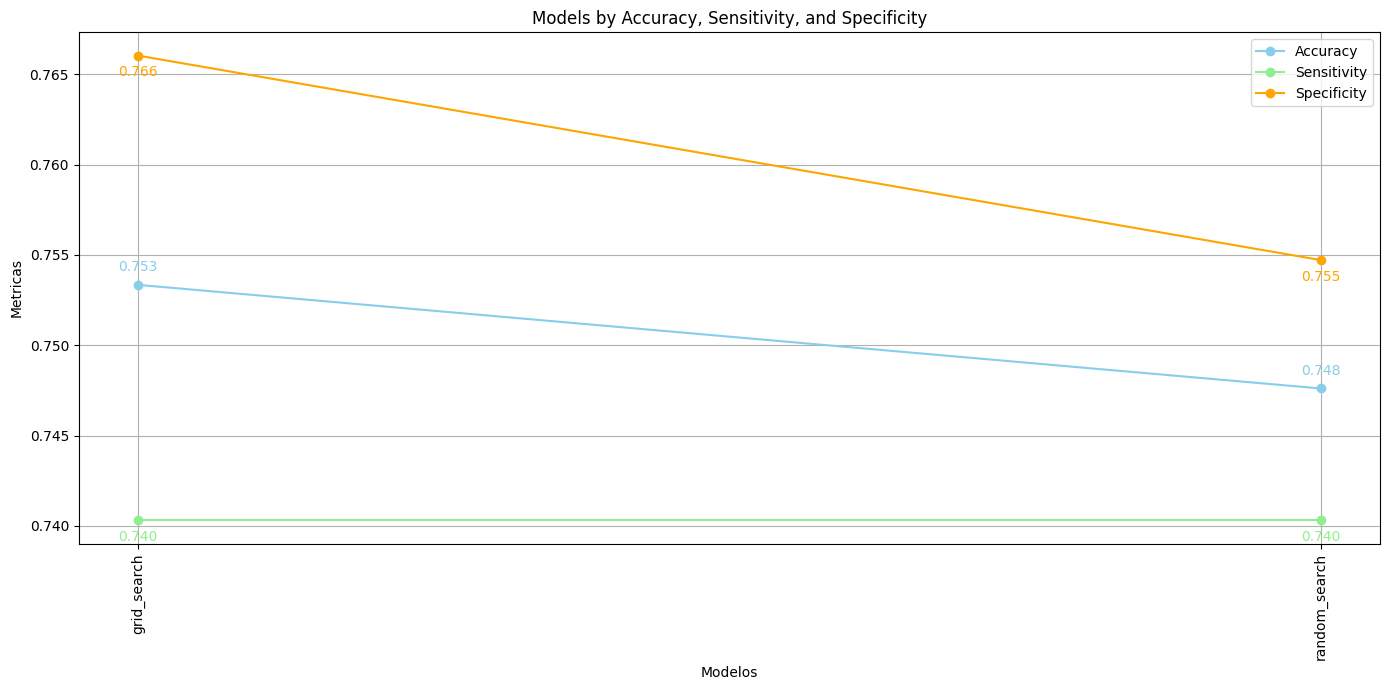

In [39]:
# Gráfico 2: Accuracy, Sensitivity y Specificity
plt.figure(figsize=(14, 7))
plt.plot(all_names, all_accuracies, label='Accuracy', marker='o', color='skyblue')
plt.plot(all_names, all_sensitivities, label='Sensitivity', marker='o', color='lightgreen')
plt.plot(all_names, all_specificities, label='Specificity', marker='o', color='orange')

# Añadir los valores a los puntos
for i, txt in enumerate(all_accuracies):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_accuracies[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='skyblue')
for i, txt in enumerate(all_sensitivities):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_sensitivities[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='lightgreen')
for i, txt in enumerate(all_specificities):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_specificities[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='orange')

plt.xlabel('Modelos')
plt.ylabel('Metricas')
plt.title('Models by Accuracy, Sensitivity, and Specificity')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()